In [1]:
import pandas as pd
import numpy as np
import nltk
import re
import heapq  
import pickle
from string import punctuation
from nltk.corpus import stopwords
punctuation = punctuation + '\n'
from nltk.stem.isri import ISRIStemmer
from nltk.tokenize import word_tokenize, sent_tokenize
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\anaconda3\lib\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\anaconda3\lib\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HP\anaconda3\lib\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\HP\anaconda3\lib\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [2]:
data = pd.read_csv('data/arabic_categorization_data.csv')

In [3]:
data

,Unnamed: 0,text,type
0,0,\nأشرف رئيس الجمهورية الباجي قايد السبسي اليوم...,culture
1,1,"\nتحصل كتاب ""المصحف وقراءاته"" الذي ألفه باحثون...",culture
2,2,\nاستنكرت إدارة المسرح الوطني التونسي الحملة ا...,culture
3,3,\nاحتضن جناح تونس في القرية الدولية للأفلام بم...,culture
4,4,\nشهدت برلين أمس الجمعة افتتاح مسجد فريد من نو...,culture
...,...,...,...
10361,4814,\nأكد المكلف بالإعلام والاتصال بالإدارة العامة...,localnews
10362,4815,\nتمكّنت فرقة الأبحاث والتفتيش للحرس الوطني بط...,localnews
10363,4816,\nقرر الأهالي بمناطق هيشر وعين القارصي والغولا...,localnews
10364,4817,\nتمكنت وحدات الحرس الوطني بمحطة الإستخلاص ببر...,localnews


In [4]:
def nltk_summarizer(input_text):
    number_of_sentence = 3
    stopWords = set(nltk.corpus.stopwords.words("arabic") + nltk.corpus.stopwords.words("english"))
    word_frequencies = {}  
    for word in nltk.word_tokenize(input_text):  
        if word not in stopWords:
            if word not in punctuation:
                if word not in word_frequencies.keys():
                    word_frequencies[word] = 1
                else:
                    word_frequencies[word] += 1

    maximum_frequncy = max(list(word_frequencies.values()),default=3)

    for word in word_frequencies.keys():  
        word_frequencies[word] = (word_frequencies[word]/maximum_frequncy)

    sentence_list = nltk.sent_tokenize(input_text)
    sentence_scores = {}  
    for sent in sentence_list:
        for word in nltk.word_tokenize(sent.lower()):
            if word in word_frequencies.keys():
                if len(sent.split(' ')) < 30:
                    if sent not in sentence_scores.keys():
                        sentence_scores[sent] = word_frequencies[word]
                    else:
                        sentence_scores[sent] += word_frequencies[word]

    summary_sentences = heapq.nlargest(number_of_sentence, sentence_scores, key=sentence_scores.get)

    summary = ' '.join(summary_sentences)  
    return summary

In [5]:
def delete_links(input_text):
    pettern  = r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))'''
    out_text = re.sub(pettern, ' ', input_text)
    return out_text

def delete_repeated_characters(input_text):
    pattern  = r'(.)\1{2,}'
    out_text = re.sub(pattern, r"\1\1", input_text)
    return out_text

def replace_letters(input_text):
    replace = {"أ": "ا","ة": "ه","إ": "ا","آ": "ا","": ""}
    replace = dict((re.escape(k), v) for k, v in replace.items()) 
    pattern = re.compile("|".join(replace.keys()))
    out_text = pattern.sub(lambda m: replace[re.escape(m.group(0))], input_text)
    return out_text

def clean_text(input_text):
    replace = r'[/(){}\[\]|@âÂ,;\?\'\"\*…؟–’،!&\+-:؛-]'
    out_text = re.sub(replace, " ", input_text)
    words = nltk.word_tokenize(out_text)
    words = [word for word in words if word.isalpha()]
    out_text = ' '.join(words)
    return out_text

def remove_vowelization(input_text):
    vowelization = re.compile(""" ّ|َ|ً|ُ|ٌ|ِ|ٍ|ْ|ـ""", re.VERBOSE)
    out_text = re.sub(vowelization, '', input_text)
    return out_text

def delete_stopwords(input_text):
    stop_words = set(nltk.corpus.stopwords.words("arabic") + nltk.corpus.stopwords.words("english"))
    tokenizer = nltk.tokenize.WhitespaceTokenizer()
    tokens = tokenizer.tokenize(input_text)
    wnl = nltk.WordNetLemmatizer()
    lemmatizedTokens =[wnl.lemmatize(t) for t in tokens]
    out_text = [w for w in lemmatizedTokens if not w in stop_words]
    out_text = ' '.join(out_text)
    return out_text

def stem_text(input_text):
    st = ISRIStemmer()
    tokenizer = nltk.tokenize.WhitespaceTokenizer()
    tokens = tokenizer.tokenize(input_text)
    out_text = [st.stem(w) for w in tokens]
    out_text = ' '.join(out_text)
    return out_text


def text_prepare(input_text, ar_text):
    out_text = delete_links(input_text)
    out_text = delete_repeated_characters(out_text)
    out_text = clean_text(out_text)
    out_text = delete_stopwords(out_text)
    if ar_text:
        out_text = replace_letters(out_text)
        out_text = remove_vowelization(out_text)
    else:
        out_text = out_text.lower()
    return out_text

In [6]:
data['Processed Text'] = data['text'].apply(text_prepare, args=(True,))

In [7]:
data

,Unnamed: 0,text,type,Processed Text
0,0,\nأشرف رئيس الجمهورية الباجي قايد السبسي اليوم...,culture,اشرف رئيس الجمهوريه الباجي قايد السبسي اليوم ب...
1,1,"\nتحصل كتاب ""المصحف وقراءاته"" الذي ألفه باحثون...",culture,تحصل كتاب المصحف وقراءاته الفه باحثون تونسيون ...
2,2,\nاستنكرت إدارة المسرح الوطني التونسي الحملة ا...,culture,استنكرت اداره المسرح الوطني التونسي الحمله شنه...
3,3,\nاحتضن جناح تونس في القرية الدولية للأفلام بم...,culture,احتضن جناح تونس القريه الدوليه للافلام بمدينه ...
4,4,\nشهدت برلين أمس الجمعة افتتاح مسجد فريد من نو...,culture,شهدت برلين الجمعه افتتاح مسجد فريد نوعه الاقل ...
...,...,...,...,...
10361,4814,\nأكد المكلف بالإعلام والاتصال بالإدارة العامة...,localnews,اكد المكلف بالاعلام والاتصال بالاداره العامه ل...
10362,4815,\nتمكّنت فرقة الأبحاث والتفتيش للحرس الوطني بط...,localnews,فرقه الابحاث والتفتيش للحرس الوطني بطبلبه ولاي...
10363,4816,\nقرر الأهالي بمناطق هيشر وعين القارصي والغولا...,localnews,قرر الاهالي بمناطق هيشر وعين القارصي والغولايث...
10364,4817,\nتمكنت وحدات الحرس الوطني بمحطة الإستخلاص ببر...,localnews,تمكنت وحدات الحرس الوطني بمحطه الاستخلاص ببرج ...


In [8]:
nltk_summarizer
data['summarizer'] = data['text'].apply(nltk_summarizer)

In [9]:
data

,Unnamed: 0,text,type,Processed Text,summarizer
0,0,\nأشرف رئيس الجمهورية الباجي قايد السبسي اليوم...,culture,اشرف رئيس الجمهوريه الباجي قايد السبسي اليوم ب...,\nأشرف رئيس الجمهورية الباجي قايد السبسي اليوم...
1,1,"\nتحصل كتاب ""المصحف وقراءاته"" الذي ألفه باحثون...",culture,تحصل كتاب المصحف وقراءاته الفه باحثون تونسيون ...,"\nتحصل كتاب ""المصحف وقراءاته"" الذي ألفه باحثون..."
2,2,\nاستنكرت إدارة المسرح الوطني التونسي الحملة ا...,culture,استنكرت اداره المسرح الوطني التونسي الحمله شنه...,
3,3,\nاحتضن جناح تونس في القرية الدولية للأفلام بم...,culture,احتضن جناح تونس القريه الدوليه للافلام بمدينه ...,تونس حاضرة من جهة أخرى ستكون تونس حاضرة في قائ...
4,4,\nشهدت برلين أمس الجمعة افتتاح مسجد فريد من نو...,culture,شهدت برلين الجمعه افتتاح مسجد فريد نوعه الاقل ...,واستأجرت صاحبة المشروع المحامية والكاتبة سيران...
...,...,...,...,...,...
10361,4814,\nأكد المكلف بالإعلام والاتصال بالإدارة العامة...,localnews,اكد المكلف بالاعلام والاتصال بالاداره العامه ل...,
10362,4815,\nتمكّنت فرقة الأبحاث والتفتيش للحرس الوطني بط...,localnews,فرقه الابحاث والتفتيش للحرس الوطني بطبلبه ولاي...,كما تمّ إلقاء القبض على عنصر رابع (عمره 32 سنة...
10363,4816,\nقرر الأهالي بمناطق هيشر وعين القارصي والغولا...,localnews,قرر الاهالي بمناطق هيشر وعين القارصي والغولايث...,وتأتي هذه الخطوة على خلفية ما اعتبره أهالي هذه...
10364,4817,\nتمكنت وحدات الحرس الوطني بمحطة الإستخلاص ببر...,localnews,تمكنت وحدات الحرس الوطني بمحطه الاستخلاص ببرج ...,\nتمكنت وحدات الحرس الوطني بمحطة الإستخلاص ببر...


In [10]:
print(data['summarizer'][100])
print('==========================================')
print(data['text'][100])



أعلنت وزارة الثقافة في بلاغ لها أنه ام تعيين كل من :
-كمال الفرجاني مدير مهرجان الحمامات  الدولي  لسنة 2014- سنية مبارك  مديرة مهرجان  قرطاج  الدولي لسنة 2014- حمدي مخلوف  مدير أيام  قرطاج  الموسيقية  لسنة  2014 -  درة بوشوشة مديرة  ايام قرطاج السينمائية  لسنة  2014- لسعد الجموسي مدير ايام  قرطاج المسرحية  لسنة  2015 - محمد  محجوب  مدير معرض  تونس الدولي للكتاب لسنة  2015



In [11]:
def aboutsummariz(text:str):
    if len(text)<10:
        ans = 'No'
    else:
        ans = "Yes"
    return ans

In [12]:
data['done?'] = data['summarizer'].apply(aboutsummariz)

In [13]:
data

,Unnamed: 0,text,type,Processed Text,summarizer,done?
0,0,\nأشرف رئيس الجمهورية الباجي قايد السبسي اليوم...,culture,اشرف رئيس الجمهوريه الباجي قايد السبسي اليوم ب...,\nأشرف رئيس الجمهورية الباجي قايد السبسي اليوم...,Yes
1,1,"\nتحصل كتاب ""المصحف وقراءاته"" الذي ألفه باحثون...",culture,تحصل كتاب المصحف وقراءاته الفه باحثون تونسيون ...,"\nتحصل كتاب ""المصحف وقراءاته"" الذي ألفه باحثون...",Yes
2,2,\nاستنكرت إدارة المسرح الوطني التونسي الحملة ا...,culture,استنكرت اداره المسرح الوطني التونسي الحمله شنه...,,No
3,3,\nاحتضن جناح تونس في القرية الدولية للأفلام بم...,culture,احتضن جناح تونس القريه الدوليه للافلام بمدينه ...,تونس حاضرة من جهة أخرى ستكون تونس حاضرة في قائ...,Yes
4,4,\nشهدت برلين أمس الجمعة افتتاح مسجد فريد من نو...,culture,شهدت برلين الجمعه افتتاح مسجد فريد نوعه الاقل ...,واستأجرت صاحبة المشروع المحامية والكاتبة سيران...,Yes
...,...,...,...,...,...,...
10361,4814,\nأكد المكلف بالإعلام والاتصال بالإدارة العامة...,localnews,اكد المكلف بالاعلام والاتصال بالاداره العامه ل...,,No
10362,4815,\nتمكّنت فرقة الأبحاث والتفتيش للحرس الوطني بط...,localnews,فرقه الابحاث والتفتيش للحرس الوطني بطبلبه ولاي...,كما تمّ إلقاء القبض على عنصر رابع (عمره 32 سنة...,Yes
10363,4816,\nقرر الأهالي بمناطق هيشر وعين القارصي والغولا...,localnews,قرر الاهالي بمناطق هيشر وعين القارصي والغولايث...,وتأتي هذه الخطوة على خلفية ما اعتبره أهالي هذه...,Yes
10364,4817,\nتمكنت وحدات الحرس الوطني بمحطة الإستخلاص ببر...,localnews,تمكنت وحدات الحرس الوطني بمحطه الاستخلاص ببرج ...,\nتمكنت وحدات الحرس الوطني بمحطة الإستخلاص ببر...,Yes


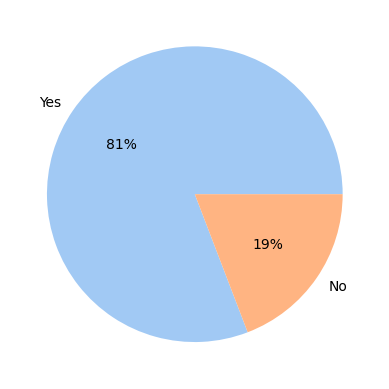

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

val = dict(data['done?'].value_counts())
labels = list(val.keys())
values = list(val.values())
colors = sns.color_palette('pastel')[0:5]
plt.pie(values, labels = labels, colors = colors, autopct='%.0f%%')
plt.show()

In [15]:
data = data[data['done?']=='Yes']
final =  data.drop(['Unnamed: 0','done?'],axis=1)

In [16]:
final.to_csv('summarizdataset.csv',index = False)